# Binary Credit Loan Decisions with Unfairness Mitigation

### Task Summary
- Injecting Bias for education purpose
- Historical Context of Credit (not Taiwan Specific)
    - Are there general ethical considerations
- Link reference to EY white paper (replicate workflow)
    - Simulate workflow using synthetic dataset
    - Be transparent about limitations of this approach

## Concrete Harms

#### Denial of Resources (Wealth)

### Negative Credit Feedback Loops

### Data Sheet

## Unmitigated Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

In [3]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [4]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate
)

In [5]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch
from fairlearn.reductions import ExponentiatedGradient

## Load and Process Dataset

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

In [7]:
rand_seed = 1234

In [8]:
data = fetch_openml(
    data_id=42477,
    cache=True,
    as_frame=True,
    return_X_y=False
)

In [9]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (pd.read_excel(io=data_url, header=1)
            .drop(columns=["ID"])
            .rename(columns={"PAY_0": "PAY_1",
                            "default payment next month": "default"})
          )

In [10]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [12]:
Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = dataset.drop(columns = ["default", "SEX"])

In [13]:
A_str = A.map({1:"male", 2:"female"})

### Add synthetic noise that is related to the outcome and sex

For the purpose of this tutorial, we add a synthetic feature `Limit` that introduces

In [14]:
# If default, Normal(2, 1) for male, Normal(2, 2) for female
# If no default, Normal(0, 1) for male, Normal(0, 2) for female
X.loc[:, "Limit"] = np.random.normal(loc=2*Y, scale=A)

### Check if this will lead to disparity in naive model

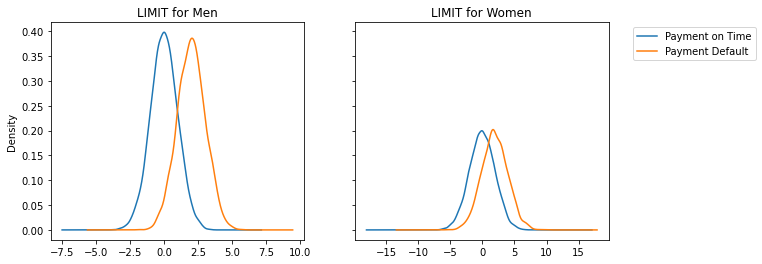

In [15]:
fig, (ax_1, ax_2) = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
X["Limit"][(A==1) & (Y==0)].plot(kind="kde", label="Payment on Time", ax=ax_1, title="LIMIT for Men")
X["Limit"][(A==1) & (Y==1)].plot(kind="kde", label="Payment Default", ax=ax_1)
X["Limit"][(A==2) & (Y==0)].plot(kind="kde", label="Payment on Time", ax=ax_2, legend=True, title="LIMIT for Women")
X["Limit"][(A==2) & (Y==1)].plot(kind="kde", label="Payment Default", ax=ax_2, legend=True).legend(bbox_to_anchor=(1.6,1))

In [16]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X,
    Y,
    A_str,
    test_size=0.25,
    stratify=Y
)

# Training a Model

In [17]:
lgb_params = {
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.03,
    "num_leaves": 10,
    "max_depth": 3
}

In [18]:
estimator = lgb.LGBMClassifier(
    **lgb_params
)

In [19]:
estimator.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [20]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = (Y_pred_proba >= np.mean(y_train)) * 1

In [21]:
roc_auc_score(y_test, Y_pred_proba)

0.874849061718832

In [22]:
fairness_metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_negative_rate": false_negative_rate
}

In [23]:
parity_metrics = {
    "demographic_parity": demographic_parity_difference,
    "equalized_odds": equalized_odds_difference
}

### Feature Importance of the Unmitigated Classifier (Using SHAP)

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

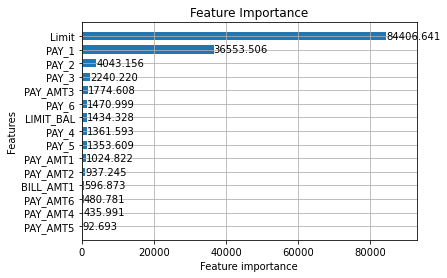

In [24]:
lgb.plot_importance(estimator, height=0.6, title="Feature Importance", importance_type="gain", max_num_features=15)

### Fairness Assessment of Unmitigated Model

In [25]:
def compute_error_metric(metric_value, sample_size):
    metric_value = metric_value/sample_size
    return 1.96*np.sqrt(metric_value*(1.0-metric_value))/np.sqrt(sample_size)

In [26]:
def error_metrics(y_test, y_pred, A_test):
    tp, tn, fp, fn = confusion_matrix(y_test, y_pred).ravel()
    error_bars = {
        "false_positive_error": compute_error_metric(fp, tn + fp),
        "false_negative_error": compute_error_metric(fn, tp + fn),
    }
    return error_bars

In [27]:
def create_difference_dataframe(metricframe, fairness_metrics, y_test, y_pred, A_test):
    differences = metricframe.difference()
    for (metric_name, metric_func) in fairness_metrics.items():
        differences[metric_name] = metric_func(y_test, y_pred, sensitive_features=A_test)
    return differences

In [28]:
metricframe_unmitigated = MetricFrame(
    fairness_metrics,
    y_test,
    Y_pred,
    sensitive_features=A_test
)

In [29]:
metricframe_unmitigated.difference()

balanced_accuracy      0.119149
selection_rate         0.052103
false_positive_rate    0.129338
false_negative_rate    0.108959
dtype: float64

In [30]:
metricframe_unmitigated.overall

balanced_accuracy      0.796622
selection_rate         0.339067
false_positive_rate    0.207841
false_negative_rate    0.198915
dtype: object

array([[<AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='SEX'>,
        <AxesSubplot:title={'center':'selection_rate'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_positive_rate'}, xlabel='SEX'>,
        <AxesSubplot:title={'center':'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

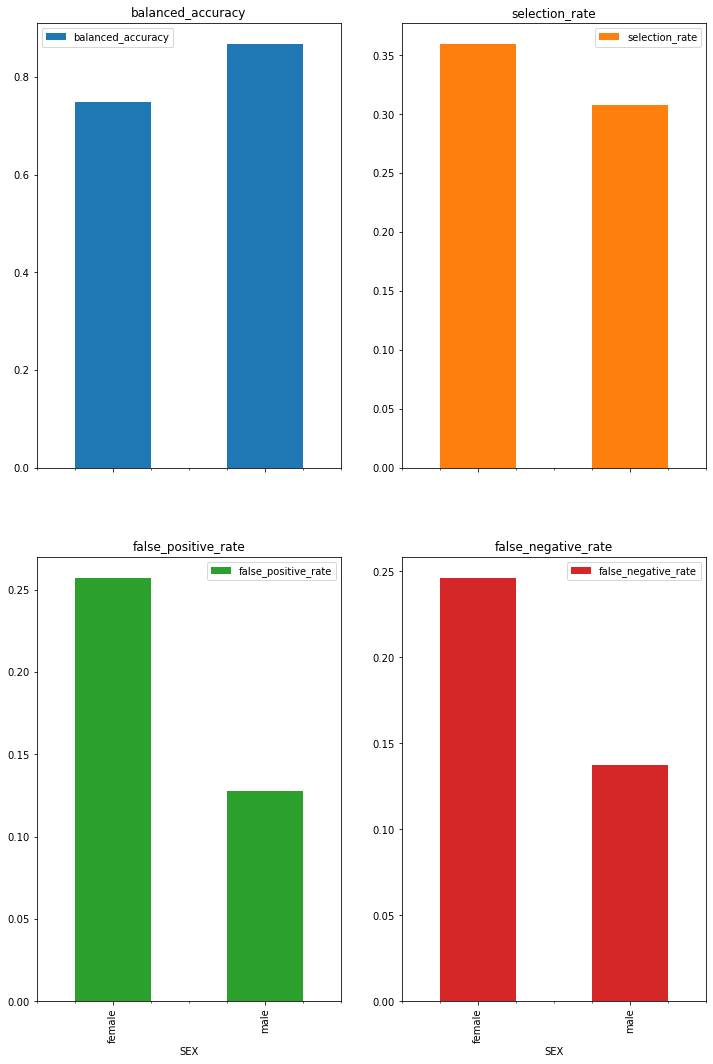

In [31]:
metricframe_unmitigated.by_group.plot.bar(subplots=True, layout=[2, 2], figsize=[12,18])

In [32]:
unmitigated_differences = create_difference_dataframe(metricframe_unmitigated, parity_metrics, y_test, Y_pred, A_test)

In [33]:
unmitigated_differences

balanced_accuracy      0.119149
selection_rate         0.052103
false_positive_rate    0.129338
false_negative_rate    0.108959
demographic_parity     0.052103
equalized_odds         0.129338
dtype: float64

In [34]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(y_test, Y_pred, sensitive_features=A_test)

# Mitigating Unfairness using Post-Processing Techniques

In [35]:
postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds",
)

In [36]:
balanced_idx1 = X_train[y_train==1].index
pp_train_idx = balanced_idx1.union(y_train[y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

In [37]:
positive_ids = y_train[y_train == 1].index
negative_ids = y_train[y_train == 0].sample(n=positive_ids.size, random_state=rand_seed).index
balanced_ids = positive_ids.union(negative_ids)

### Re-balance the training dataset

In [38]:
X_train_balanced = X_train.loc[pp_train_idx,:]
y_train_balanced = y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [39]:
postprocess_est.fit(
    X=X_train_balanced,
    y=y_train_balanced,
    sensitive_features=A_train_balanced
)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'))

In [40]:
postprocess_pred = postprocess_est.predict(
    X_test,
    sensitive_features=A_test
)

In [41]:
postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test,
    sensitive_features=A_test
)

### Fairness Assessment of post-processing model

In [42]:
mf_postprocess = MetricFrame(
    fairness_metrics,
    y_test,
    postprocess_pred,
    sensitive_features=A_test
)

In [43]:
mf_postprocess.overall

balanced_accuracy      0.752063
selection_rate         0.363867
false_positive_rate    0.252354
false_negative_rate     0.24352
dtype: object

In [44]:
mf_postprocess.difference()

balanced_accuracy      0.014467
selection_rate         0.020447
false_positive_rate    0.005439
false_negative_rate    0.023496
dtype: float64

array([[<AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='SEX'>,
        <AxesSubplot:title={'center':'selection_rate'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_positive_rate'}, xlabel='SEX'>,
        <AxesSubplot:title={'center':'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

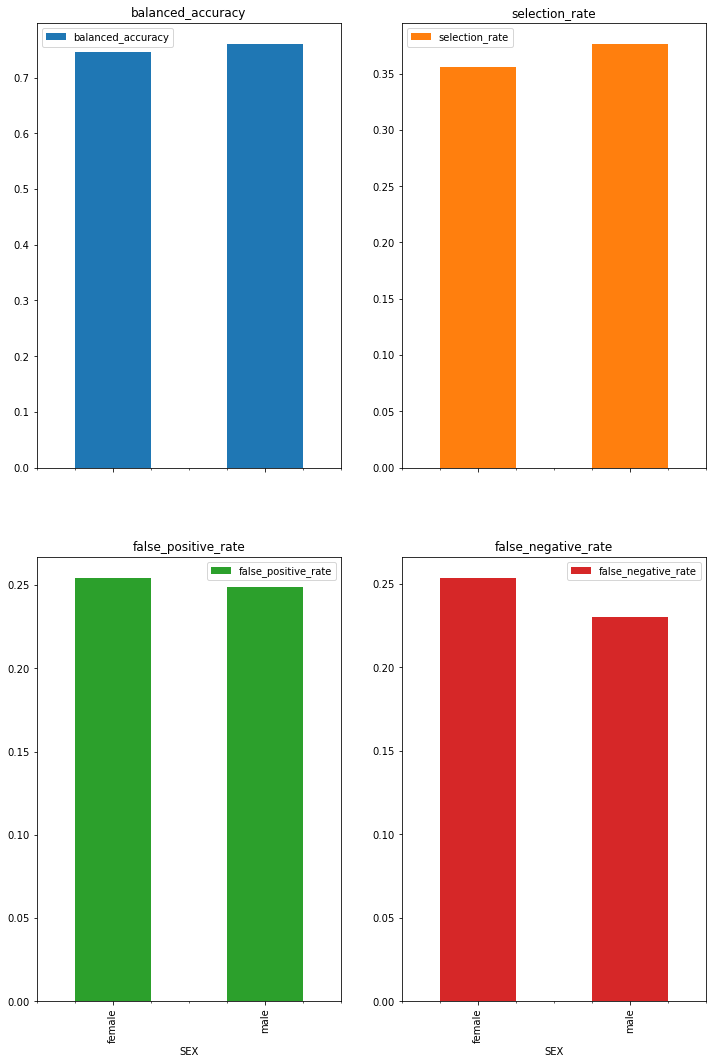

In [45]:
mf_postprocess.by_group.plot.bar(subplots=True, layout=[2, 2], figsize=[12,18])

In [46]:
postprocess_differences = create_difference_dataframe(mf_postprocess, parity_metrics, y_test, postprocess_pred, A_test)

In [47]:
postprocess_differences

balanced_accuracy      0.014467
selection_rate         0.020447
false_positive_rate    0.005439
false_negative_rate    0.023496
demographic_parity     0.020447
equalized_odds         0.023496
dtype: float64

#### Add callout to unawareness issue

### Feature Importance of Post-Processed Model

## Mitigating Unfairness using GridSearch

#### Replace with Exponentiated Gradient
- Try the Exponentiated Gradient with different Lambdas
    - Are epsilons the lambdas?
    - Want some amounts of trade-offs
    - Returns a randomized classifier
        - Re-run Grid Search with those lambdas

In [48]:
def compute_model_performance(model, X_test, y_test, A_test, baseline):
    model_pred_proba = model.predict_proba(X_test)[:,1]
    model_pred = (model_pred_proba >= baseline)*1
    roc = roc_auc_score(y_test, model_pred_proba)
    equal_odds_diff = equalized_odds_difference(y_test, model_pred, sensitive_features=A_test)
    return (roc, equal_odds_diff)

In [49]:
from fairlearn.reductions import EqualizedOdds

In [50]:
epsilons = [0.01, 0.02]

In [51]:
def get_expgrad_models_per_epsilon(estimator, epsilon):
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        constraints=EqualizedOdds(difference_bound=epsilon)
    )
    #Is this an issue - Re-runs
    exp_grad_est.fit(X_train_balanced, y_train_balanced, sensitive_features=A_train_balanced)
    predictors = exp_grad_est.predictors_
    return predictors

In [52]:
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(estimator=estimator, epsilon=eps)

In [53]:
# Loop through different bounds, take all 80 classifiers
# Raster plot with 100 points, focus on seeing the trade-offs
# Check for most interesting; given random seed

# Select best model

In [54]:
def aggregate_predictor_performances(predictors, metric, X_test, Y_test, A_test=None):
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [metric(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in all_predictions]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [55]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(models, equalized_odds_difference, X_test, y_test, A_test)
        bal_acc_score = aggregate_predictor_performances(models, balanced_accuracy_score, X_test, y_test)
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((
                eps,
                i,
                score,
                bal_acc_score[i]
            ))
    performances_df = pd.DataFrame.from_records(performances,
                                               columns=["epsilon", "index", "equalized_odds", "balanced_accuracy"])    
    return performances_df

In [56]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)

In [57]:
performance_df

,epsilon,index,equalized_odds,balanced_accuracy
0,0.01,0,0.128087,0.793385
1,0.01,1,0.128469,0.793344
2,0.01,2,0.344125,0.349539
3,0.01,3,0.123037,0.795101
4,0.01,4,0.360134,0.347557
5,0.01,5,0.119400,0.795391
6,0.01,6,0.209453,0.522662
7,0.01,7,0.113491,0.795648
8,0.01,8,0.182015,0.684357
9,0.01,9,0.107638,0.795418


### Performance Plots of ExponentiatedGradient Model

In [58]:
exp_grad_est = ExponentiatedGradient(
    estimator=estimator,
    constraints=EqualizedOdds(difference_bound=0.02)
)

In [59]:
exp_grad_est.fit(X_train_balanced, y_train_balanced, sensitive_features=A_train_balanced)

In [60]:
y_pred_inprocess = exp_grad_est.predict(X_test, random_state=rand_seed)

In [61]:
mf_inprocess = MetricFrame(
    fairness_metrics,
    y_test,
    y_pred_inprocess,
    sensitive_features=A_test
)

In [62]:
mf_inprocess.difference()

balanced_accuracy      0.066109
selection_rate         0.003218
false_positive_rate    0.054973
false_negative_rate    0.077246
dtype: float64

In [63]:
mf_inprocess.overall

balanced_accuracy      0.781365
selection_rate           0.3128
false_positive_rate    0.188324
false_negative_rate    0.248945
dtype: object

array([[<AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='SEX'>,
        <AxesSubplot:title={'center':'selection_rate'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_positive_rate'}, xlabel='SEX'>,
        <AxesSubplot:title={'center':'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

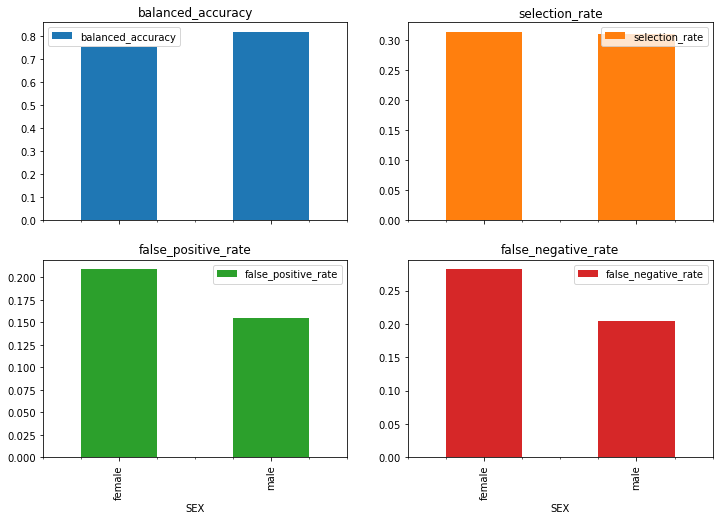

In [64]:
mf_inprocess.by_group.plot.bar(subplots=True, layout=[2, 2], figsize=[12, 8])

In [65]:
inprocess_differences = create_difference_dataframe(mf_inprocess, parity_metrics, y_test, y_pred_inprocess, A_test)

In [66]:
inprocess_differences

balanced_accuracy      0.066109
selection_rate         0.003218
false_positive_rate    0.054973
false_negative_rate    0.077246
demographic_parity     0.003218
equalized_odds         0.077246
dtype: float64

In [67]:
# Pass Lambda_vecs as Grid_offset to Grid_search
# Do a couple of Exponentiated Gradient, and combine the predictors (Boosting?)
# Just run Exp_Gradient with different trade-off points -> Each classifier staddles a variety of trade-offs -> Pick one of these 19 classifiers
# Plot the GridSearch graph with these 19 classifiers

### Feature Importance of ExponentiatedGradient Model

In [68]:
all_models.keys()

dict_keys([0.01, 0.02])

In [69]:
model_performances = {}

In [70]:
for (eps, models) in all_models.items():    
    eq_odds_inprocess = aggregate_predictor_performances(models, equalized_odds_difference, X_test, y_test, A_test)
    bal_accuracy_inprocess = aggregate_predictor_performances(models, balanced_accuracy_score, X_test, y_test)
    model_performances[eps] = (eq_odds_inprocess, bal_accuracy_inprocess)

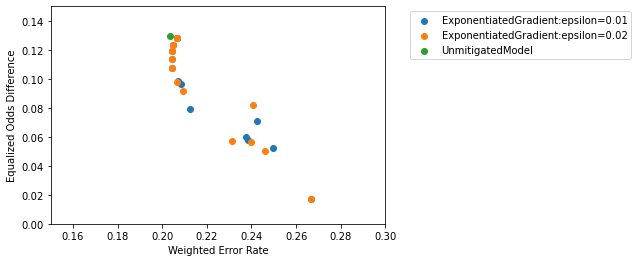

In [71]:
for (eps, (eq, bal_acc)) in model_performances.items():
    if eps != 0.05:
        plt.scatter([1 - bas for bas in bal_acc], eq, label=f"ExponentiatedGradient:epsilon={eps}")
plt.scatter(1.0 - balanced_accuracy_unmitigated, equalized_odds_unmitigated,label=f'UnmitigatedModel')
#plt.scatter(1.0 - balanced_accuracy_postprocessing, equalized_odds_postprocessing,label=f"ThresholdOptimizer")
plt.xlim([0.15, 0.3])
plt.ylim([0, 0.15])
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.75,1))
plt.show()

#### Report model performance error bars for metrics

### Workflow for undominated models (IN PROGRESS)

Send similar plot for 0.01, 0.02; Look at dominance plots

In [72]:
def exclude_dominated_models(model_performances):
    non_dominated = {}
    for eps in model_performances.keys():
        for (i, (eq_odds, bal_acc)) in enumrate(model_performances[eps]):
            
        

SyntaxError: unexpected EOF while parsing (<ipython-input-72-360504ed07d5>, line 6)

In [ ]:
eq, bas = model_performances[0.02]
bas = [1.0 - ba for ba in bas]

In [ ]:
for i, ba in enumerate(bas):
    if eq[i] < 0.05: 
        print(i, ba, eq[i])

### Discuss Performance and Trade-Offs

In [ ]:
differences_dict = {
    "Unmitigated": unmitigated_differences,
    "Postprocessing": postprocess_differences,
    "ExponentiatedGrad": inprocess_differences
}

In [ ]:
differences_df = pd.DataFrame.from_dict(differences_dict)

In [ ]:
differences_df.plot.bar()

In [ ]:
performance_dict = {
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": mf_postprocess.overall,
    "ExponentiatedGrad": mf_inprocess.overall
}

In [ ]:
overall_df = pd.DataFrame.from_dict(performance_dict)

In [ ]:
overall_df.plot.bar()

# Designing a Model Card (Stretch Goal)
- Capture reasoning, and link to Model Card resource if don't have time

In [ ]:
import model_card_toolkit

In [ ]:
model_card_path = Path(os.getcwd())
mct = model_card_toolkit.ModelCardToolkit(model_card_path)

In [ ]:
model_card = mct.scaffold_assets()

In [ ]:
model_card.model_details.name = "Credit Loan Default Model"
model_card.model_details.overview = "This model predicts whether an applicant will default on a credit loan"
model_card.model_details.users = ["Financial Institutions", "Data Scientists"]
model_card.model_details.ethical_concerns = [
 {
     
 }   
]

## Discussion

### Fairness Under Unawareness

When proving credit models are compliant with fair lending laws, practitoners often run into the issue 

### Fairness is not the same as anti-discrimination